In [2]:
from pandas.core.interchange.dataframe_protocol import DataFrame
# ============================================================
# Notebook setup: run this before everything
# ============================================================
# -- Copied from lecture
%load_ext autoreload
%config IPCompleter.greedy=True
%autoreload 1
%aimport util
from util import util
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.neighbors import KernelDensity
from sklearn.metrics import mean_squared_error
from IPython.display import display
from collections import Counter
import seaborn as sns


# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 4)

data_folder = '../resources/dataset'
file_name = '7_gecco2019_train_water_quality.csv'
# Load the input data
data_path = f'{data_folder}/{file_name}'
raw_data = pd.read_csv(data_path)
raw_data['Time'] = pd.to_datetime(raw_data['Time'])
raw_data.set_index('Time', inplace=True)
raw_data = raw_data.drop(columns=["Unnamed: 0"]) # The index was stored as an unnamed column

# Missing Values
## Investigation

First, we see that most of our values are floating point numbers, except for the `Event` column which is our label, that is,
whether we are dealing with an anomaly or not.

In [3]:
print("Columns: ")
print({column: raw_data[column].dtype for column in raw_data.columns})
raw_data.describe()

Columns: 
{'Tp': dtype('float64'), 'pH': dtype('float64'), 'Cond': dtype('float64'), 'Turb': dtype('float64'), 'SAC': dtype('float64'), 'PFM': dtype('float64'), 'Event': dtype('bool')}


,Tp,pH,Cond,Turb,SAC,PFM
count,132266.000000,132272.000000,132276.000000,132275.000000,132280.000000,132269.000000
mean,8.041982,8.533168,0.021095,0.128368,4.100425,68.660980
std,0.893687,0.052646,0.000347,0.005928,0.304104,11.420472
min,0.000000,0.000000,0.000000,0.000000,0.000000,42.163100
25%,7.250000,8.502780,0.020871,0.127160,3.816430,60.484900
50%,7.880000,8.539630,0.021102,0.127754,4.125515,71.440700
75%,8.710000,8.563490,0.021327,0.128686,4.395750,79.076900
max,10.300000,8.666760,0.023214,1.782850,6.102071,84.815100


We will now look at the alignment and completeness of the sample timeslots:

In [4]:
(raw_data.index[1:] - raw_data.index[:-1]).value_counts()

Time
0 days 00:01:00    132479
Name: count, dtype: int64

We see that the timeslots are regular and not missing.

Now, we will look at missing values:

In [5]:
print("Columns containing missing values:")
print(raw_data.isna().any())
print("Some rows containing missing values:")
raw_data.loc[raw_data.isna().any(axis=1)].head()

Columns containing missing values:
Tp        True
pH        True
Cond      True
Turb      True
SAC       True
PFM       True
Event    False
dtype: bool
Some rows containing missing values:


,Tp,pH,Cond,Turb,SAC,PFM,Event
Time,,,,,,,
2017-07-01 13:24:00,NaN,NaN,NaN,NaN,NaN,NaN,False
2017-07-01 17:00:00,NaN,8.58873,NaN,0.126537,3.58901,NaN,False
2017-07-02 22:08:00,NaN,NaN,NaN,NaN,NaN,NaN,False
2017-07-03 01:46:00,7.1,8.55185,0.021717,NaN,NaN,44.7191,False
2017-07-03 05:23:00,NaN,NaN,NaN,NaN,NaN,NaN,False


As we can see, there are quite a few missing values in our dataset. Each column has some.

We will now try to characterize the distribution in which they show up.

In [6]:

for column in raw_data.drop(columns=["Event"]).columns:
    print()
    print("Column:", util.bold(column))
    series = util.calculate_na_series(raw_data[column])
    for length, count in Counter(map(int, series[:, 1])).most_common():
        print(f"There are {util.bold(count)} NA-sequences of length {util.bold(length)}")


Column: Tp
There are 201 NA-sequences of length 1
There are 1 NA-sequences of length 3
There are 1 NA-sequences of length 10

Column: pH
There are 195 NA-sequences of length 1
There are 1 NA-sequences of length 3
There are 1 NA-sequences of length 10

Column: Cond
There are 191 NA-sequences of length 1
There are 1 NA-sequences of length 3
There are 1 NA-sequences of length 10

Column: Turb
There are 195 NA-sequences of length 1
There are 1 NA-sequences of length 10

Column: SAC
There are 188 NA-sequences of length 1
There are 1 NA-sequences of length 2
There are 1 NA-sequences of length 10

Column: PFM
There are 198 NA-sequences of length 1
There are 1 NA-sequences of length 3
There are 1 NA-sequences of length 10


We see that most missing values just come up randomly and not in a bunch.
The segments of 10 consecutive NA values across all columns seems suspicious though.

Let's see if this is the same for all.

In [7]:
collective_na_series = util.calculate_true_series(raw_data.drop(columns="Event").isna().to_numpy().all(axis=1))
collective_na_series[collective_na_series[:,1] > 1]

array([[78550,    10]])

Indeed, we see that there is only one index with a series of timestamps where all entries are 0 (that is more than timeslot long).
It starts at index 78550.

Since most of them however, just come up individually, we would expect that naive filling algorithms should perform well enough as more complex ones.

By the way, respectively the other series' with more than one consecutive Na look like this. Note that all of them are classified as an anomaly.

In [8]:
for column in raw_data.drop(columns="Event").columns:
    longer_segments = series[np.logical_and(series[:, 1] > 1, series[:, 1] < 10)]
    display([raw_data.iloc[i:i + l] for i, l in longer_segments])

[                     Tp  pH  Cond      Turb      SAC  PFM  Event
 Time                                                            
 2017-08-24 12:42:00 NaN NaN   NaN  0.153299  4.24212  NaN   True
 2017-08-24 12:43:00 NaN NaN   NaN  0.158719      NaN  NaN   True
 2017-08-24 12:44:00 NaN NaN   NaN       NaN      NaN  NaN   True]

[                     Tp  pH  Cond      Turb      SAC  PFM  Event
 Time                                                            
 2017-08-24 12:42:00 NaN NaN   NaN  0.153299  4.24212  NaN   True
 2017-08-24 12:43:00 NaN NaN   NaN  0.158719      NaN  NaN   True
 2017-08-24 12:44:00 NaN NaN   NaN       NaN      NaN  NaN   True]

[                     Tp  pH  Cond      Turb      SAC  PFM  Event
 Time                                                            
 2017-08-24 12:42:00 NaN NaN   NaN  0.153299  4.24212  NaN   True
 2017-08-24 12:43:00 NaN NaN   NaN  0.158719      NaN  NaN   True
 2017-08-24 12:44:00 NaN NaN   NaN       NaN      NaN  NaN   True]

[                     Tp  pH  Cond      Turb      SAC  PFM  Event
 Time                                                            
 2017-08-24 12:42:00 NaN NaN   NaN  0.153299  4.24212  NaN   True
 2017-08-24 12:43:00 NaN NaN   NaN  0.158719      NaN  NaN   True
 2017-08-24 12:44:00 NaN NaN   NaN       NaN      NaN  NaN   True]

[                     Tp  pH  Cond      Turb      SAC  PFM  Event
 Time                                                            
 2017-08-24 12:42:00 NaN NaN   NaN  0.153299  4.24212  NaN   True
 2017-08-24 12:43:00 NaN NaN   NaN  0.158719      NaN  NaN   True
 2017-08-24 12:44:00 NaN NaN   NaN       NaN      NaN  NaN   True]

[                     Tp  pH  Cond      Turb      SAC  PFM  Event
 Time                                                            
 2017-08-24 12:42:00 NaN NaN   NaN  0.153299  4.24212  NaN   True
 2017-08-24 12:43:00 NaN NaN   NaN  0.158719      NaN  NaN   True
 2017-08-24 12:44:00 NaN NaN   NaN       NaN      NaN  NaN   True]

# Filling missing values
We want to try and evaluate all methods separately. We will evaluate it using the RMSE analogously to the lecture.
I.e., we will look for mostly intact segments, remove values arbitrarily, and then fill them using the methods.
## Simple Filling
Because filling values for one column is independent of the others, we can fill the missing values for each column separately in order to maximize the size of the validation set.
Prior, we calculate the proportion of Na values in the entire column and delete the same
proportion from our validation set.
Assuming the missing values are uniformly randomly distributed, our calculated error will tend towards the true error of our method.

In [9]:
# Initialize a list to collect statistics for each column
stats_list = []
permitted_missing_values = 10
filled_data = pd.DataFrame(index=raw_data.index)
for column in raw_data.columns:
    if column == "Event":
        filled_data[column] = raw_data[column]
        continue
    # Find the best segment
    segment_bounds = util.find_best_segment_in_series(raw_data[column], permitted_missing_values)
    segment = raw_data[column].iloc[segment_bounds[0]:segment_bounds[1]]
    nan_mask = segment.isnull()

    # Calculate statistics
    na_proportion = raw_data[column].isna().sum() / len(segment)
    drop_count = round(len(segment) * na_proportion)

    # Introduce missing values at random positions
    np.random.seed(42)  # Seed for reproducibility
    mv_idx = np.random.choice(np.arange(len(segment)), size=drop_count, replace=False)
    segment_mv = segment.copy()
    segment_mv.iloc[mv_idx] = np.nan

    # Define interpolation methods
    args = [
        {'method': 'linear'},
        {'method': 'polynomial', 'order': 2},
        {'method': 'spline', 'order': 4},
        {'method': 'nearest'}
    ]

    min_rmse = float('inf')
    min_fill_function = None
    min_name = None

    # Function to calculate RMSE and update stats
    rmse_methods = {}
    def calc_rmse(name, fill_function):
        global min_rmse, min_fill_function, min_name
        filled = fill_function(segment_mv)
        rmse = np.sqrt(mean_squared_error(segment[~nan_mask], filled[~nan_mask]))
        # Store RMSE for this method in the stats dictionary
        rmse_methods[f'RMSE {name}'] = rmse
        if rmse < min_rmse:
            min_rmse, min_fill_function, min_name = rmse, fill_function, name

    # Calculate RMSE for each method
    for a in args:
        method_name = a.get('method')
        # Capture 'a' in the lambda to avoid late binding
        calc_rmse(method_name, lambda arr, a=a: arr.interpolate(**a))
    calc_rmse("ffill", lambda arr: arr.ffill())
    calc_rmse("bfill", lambda arr: arr.bfill())

    filled_data[column] = min_fill_function(raw_data[column])

    # Initialize stats dictionary for this column
    stats = {
        'Column': column,
        'Best method': min_name,
        'Best RMSE': min_rmse,
        **rmse_methods,
        '# samples in Validation': len(segment),
        '% of NaN in entire column': na_proportion,
        '# Deleted for test set': drop_count,
        '# NA in validation set': segment.isna().sum()
    }

    stats_list.append(stats)

# Create DataFrame from collected stats
stats_df = pd.DataFrame(stats_list)

# Optional: Set 'Column' as the index
stats_df.set_index('Column', inplace=True)

# Display the DataFrame
stats_df.T

Column,Tp,pH,Cond,Turb,SAC,PFM
Best method,linear,linear,linear,spline,linear,linear
Best RMSE,0.000583,0.000174,0.0,0.000142,0.00078,0.080613
RMSE linear,0.000583,0.000174,0.0,0.000192,0.00078,0.080613
RMSE polynomial,0.000658,0.000218,0.000001,0.000281,0.000952,0.09578
RMSE spline,0.007113,0.002115,0.000025,0.000142,0.001469,0.106017
RMSE nearest,0.000815,0.000218,0.000001,0.000327,0.000891,0.093488
RMSE ffill,0.000795,0.000217,0.000001,0.000327,0.000892,0.09349
RMSE bfill,0.000919,0.000217,0.000001,0.000188,0.000911,0.091582
# samples in Validation,15050,16071,15477,15266,13958,15050
% of NaN in entire column,0.014219,0.012943,0.013181,0.013429,0.014329,0.01402


This table shows the performance of each method as well as stats like the proportion of Na values in the column and the number of deleted samples for producing the test set with missing values.

As expected, there is not much difference between the methods.
Overall, the linear method seems to perform the best.

Since we do not have an expedient number of missing values, we will forgo trying Gaussian Processes for missing value reconstruction.

Ultimately, we use the best method for each column to fill the missing values in the entire dataset.

# Standardize the data

In [10]:
std_data = raw_data.copy()
data_columns = list(std_data.columns[0:-1])
std_data[data_columns] = (std_data[data_columns] - std_data[data_columns].mean()) / std_data[data_columns].std()
std_data["Event"] = std_data["Event"].astype(int)

# Visualize the data
## Heatmap over the whole timespan

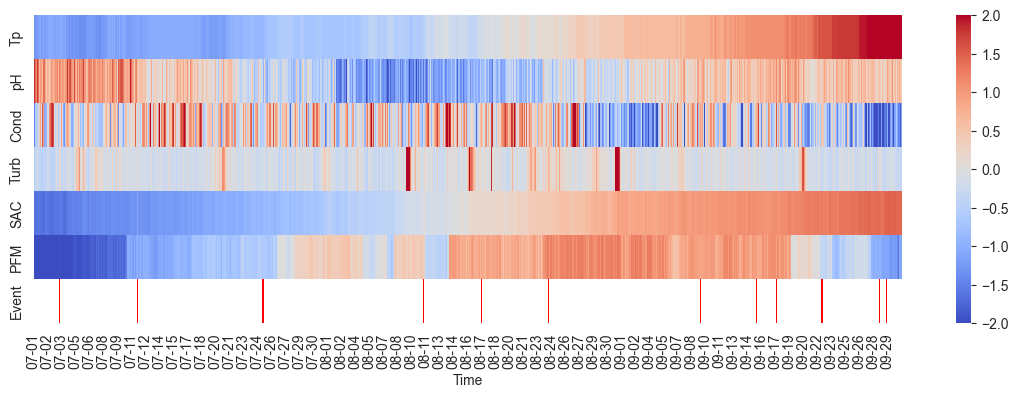

In [11]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=figsize)

# Example data with 7 rows
data = std_data.copy()
data[data_columns] = data[data_columns].clip(-2, 2)
data["Event"] = data["Event"].astype(int)
events = data[data["Event"] > 0]
data['Event'] = data['Event'].rolling(window=151, center=True, min_periods=1).max()
data.index = data.index.strftime('%m-%d')

data = data.T

# First mask: show only rows 0-5
mask1 = np.zeros_like(data, dtype=bool)
mask1[-1, :] = True  # hide last row

# Second mask: show only the last row
mask2 = np.ones_like(data, dtype=bool)
mask2[-1, :] = False  # hide first 6 rows

sns.heatmap(data, ax=ax, cmap="coolwarm", mask=mask1)
sns.heatmap(data, ax=ax, cmap=ListedColormap(["white", "red"]), mask=mask2, cbar=False)
# ax.set_xticks(ax.get_xticks()[::2])
# plt.xticks(rotation=45)

plt.show()

## Auto Correlation Plot

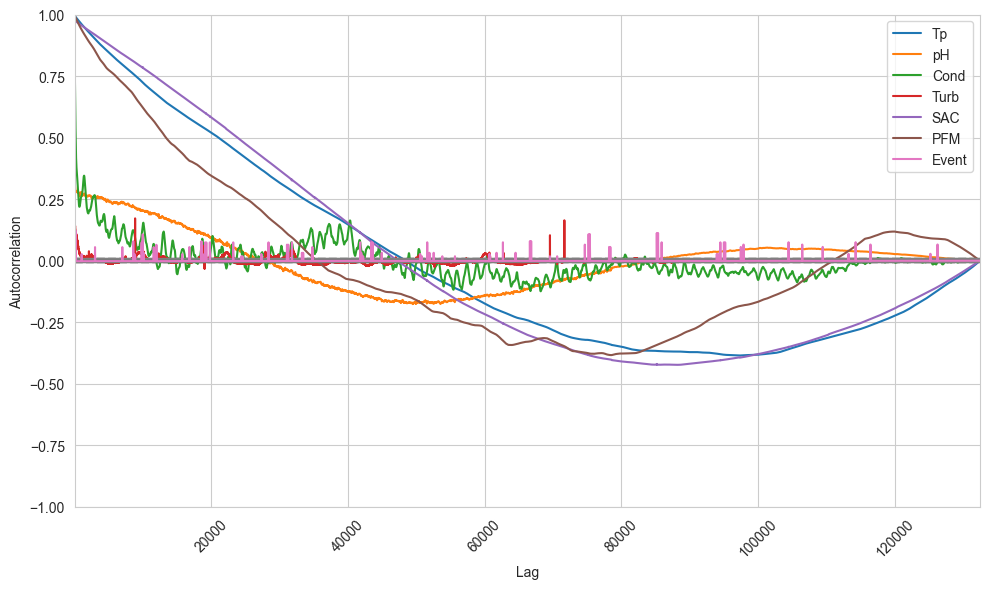

In [15]:
%%capture --no-display expensive_output
util.plot_multiple_autocorrelations([filled_data[c] for c in filled_data.columns], figsize)

- For `Tp`, `SAC` and less so `PFM`, we observe strong temporal correlation and possibly periodic behavior with a very long period.
- For `pH` and `Cond`, it seems that only one 4th of values are temporally correlated at maximum. They seem to be periodic with small and varying periods.
- `Turb` seems neither periodic nor temporally correlated. There are spikes of correlation, which might indicate anomalies or noise, which have strong momentum with respect to the rest of the column.

Indeed, the inter–column–correlation matrix roughly confirms these correlations:

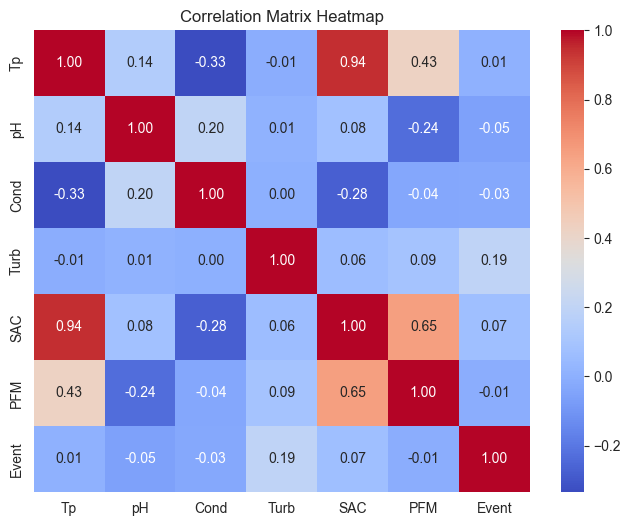

In [16]:
# Calculate the correlation matrix
correlation_matrix = filled_data.corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")

# Display the heatmap
plt.title("Correlation Matrix Heatmap")
plt.show()

# Anomaly Detection
## Kernel Density Estimation
Since we just saw that the temporal correlation is strong and even periodic at times, we will augment the data with their timestamps as proper features.

In [14]:
timed_data = filled_data.copy()
timed_data['Time'] = timed_data.index.hour + timed_data.index.minute / 60

# Initialize the KDE model
kde = KernelDensity(bandwidth=1, kernel='gaussian')
kde.fit(timed_data)


KernelDensity(bandwidth=1)

## Test for markov property

In the lectures, wen defined the alarm signal we strive to minimize:
$$
-\log f(x, θ) \geq ε
$$
where $$ f(x, θ) $$ is the true distribution function.

## Investigation
Determining the period:

# Multivariate Kernel Density Estimation
The first approach presented in the lecture is **Kernel Density Estimation**

In order to employ **KDE**, we need to determine the optimal **Kernel Function** and **Bandwidth**. 
Since we have multiple columns, we cannot use the Rule Of Thumb for the latter. Therefore, we need to optimize the following term according to the lecture: 
$$
\mathop{\arg\max}_{h} \mathbb{E}_{x \sim f(x), \bar{x} \sim f(x)}\left[ L(h, x, \bar{x})\right]
$$
where
- $$
L(h, x, \bar{x}) = \prod_{i=1}^m \hat{f}(x_i, \bar{x}_i, h)
$$
- $\hat{f}$ is the density estimator (which outputs a probability)
- $\bar{x}$ the training set

according to the lecture.
